In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
from IPython.display import clear_output
!pip install tf_explain
! pip install segmentation-models
clear_output()
from tf_explain.core.grad_cam import GradCAM

#!pip install git+git://github.com/stared/livelossplot.git
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#import utils
import os
%matplotlib inline

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Flatten, Dense, Reshape, Multiply, Add,UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


import tensorflow as tf
from keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
# from livelossplot import PlotLossesTensorFlo

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os,cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# kNN

In [ ]:
df = pd.read_csv("gdrive/MyDrive/fer2013.csv")

In [ ]:
traindf = df[df['Usage']=='Training']

In [ ]:
traindf.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
x_data = traindf['pixels']
y_data = traindf['emotion']

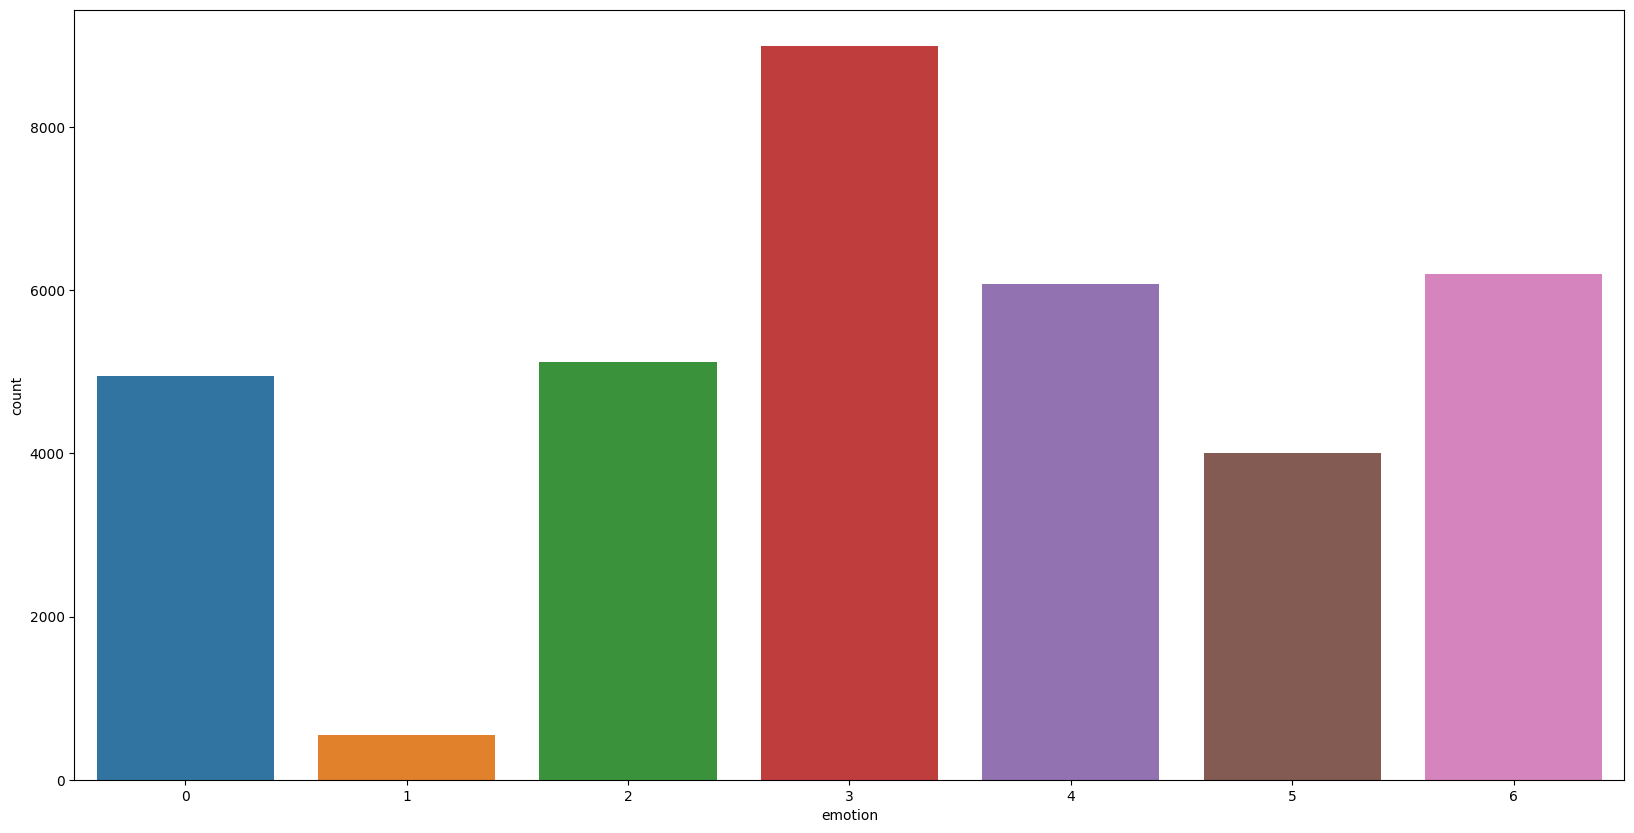

In [ ]:
ax = sns.countplot(x="emotion", data=df)


Inference: An imbalance of data is observed as some classes like 1 have very low instances while class 3 has more no. of instances

To overcome, we go for resampling the data by generating new data of minority classes and store it as new train dataset.

In [ ]:
from imblearn.over_sampling import RandomOverSampler
oversampler = RandomOverSampler(sampling_strategy='auto')

x_data, y_data = oversampler.fit_resample(x_data.values.reshape(-1,1), y_data)
print(x_data.shape," ",y_data.shape)

(50505, 1)   (50505,)


In [ ]:
x_data = pd.Series(x_data.flatten())
x_data = np.array(list(map(str.split, x_data)), np.float32)
x_data /= 255
x_data[:10]

array([[0.27450982, 0.3137255 , 0.32156864, ..., 0.41568628, 0.42745098,
        0.32156864],
       [0.5921569 , 0.5882353 , 0.5764706 , ..., 0.75686276, 0.7176471 ,
        0.72156864],
       [0.90588236, 0.83137256, 0.6117647 , ..., 0.34509805, 0.43137255,
        0.59607846],
       ...,
       [0.3019608 , 0.30588236, 0.30980393, ..., 0.49019608, 0.2627451 ,
        0.26666668],
       [0.33333334, 0.32941177, 0.3529412 , ..., 0.22745098, 0.28627452,
        0.32941177],
       [1.        , 0.99607843, 1.        , ..., 0.99607843, 1.        ,
        1.        ]], dtype=float32)

In [ ]:
y_data = np.array(y_data)

In [ ]:
x_data = x_data.reshape(-1, 48, 48, 1)
y_data = y_data.reshape(y_data.shape[0], 1)
x_data.shape,y_data.shape

((50505, 48, 48, 1), (50505, 1))

In [ ]:
x_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.1, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
print("x_train: "+str(x_train.shape))
print("X_test: "+str(X_test.shape))
print("X_val: "+str(X_val.shape))
print("y_train: "+str(y_train.shape))
print("y_test: "+str(y_test.shape))
print("y_val: "+str(y_val.shape))

x_train: (45454, 48, 48, 1)
X_test: (2526, 48, 48, 1)
X_val: (2525, 48, 48, 1)
y_train: (45454, 1)
y_test: (2526, 1)
y_val: (2525, 1)


In [ ]:
from builtins import range
from builtins import object

num_training = x_train.shape[0]
mask = list(range(num_training))
X_train = x_train[mask]
y_train = y_train[mask]

num_test = X_test.shape[0]
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

num_val = X_val.shape[0]
mask = list(range(num_val))
X_val = X_val[mask]
y_val = y_val[mask]

# Reshape the image data into rows
X_train = np.reshape(x_train, (x_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))

print("x_train: "+str(x_train.shape))
print("X_test: "+str(X_test.shape))
print("X_val: "+str(X_val.shape))
print("y_train: "+str(y_train.shape))
print("y_test: "+str(y_test.shape))
print("y_val: "+str(y_val.shape))

x_train: (45454, 48, 48, 1)
X_test: (2526, 2304)
X_val: (2525, 2304)
y_train: (45454, 1)
y_test: (2526, 1)
y_val: (2525, 1)


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings('ignore')

Reshape 4D x_train np array (45454,48,48,1) into 2D array by taking row size as 45454 and columns as 48x48x1

In [ ]:
nsamples, nx, ny, nz = x_train.shape
d2_train_dataset = x_train.reshape((nsamples,nx*ny*nz))

In [ ]:
print("Val Accuracy for k=1")
classifier = KNeighborsClassifier(n_neighbors=1)
classifier.fit(d2_train_dataset, y_train)

Val Accuracy for k=1


KNeighborsClassifier(n_neighbors=1)

In [ ]:
# Calculate the accuracy of the model 
print("Accuracy of the model for validation dataset:")
print(classifier.score(X_val, y_val))

Accuracy of the model for validation dataset:
0.7572277227722772


In [ ]:
# Calculate the accuracy of the model 
print("Accuracy of the model for test dataset:")
print(classifier.score(X_test, y_test))

Accuracy of the model for test dataset:
0.7743467933491687


In [ ]:
# Calculate the accuracy of the test FER dataset
testdf = df[df['Usage']=='PublicTest']
# testdf.head()
X_test = testdf['pixels']
y_test = testdf['emotion']
oversamp = RandomOverSampler(sampling_strategy='auto')
Xt, yt = oversamp.fit_resample(X_test.values.reshape(-1,1), y_test)
Xt = pd.Series(Xt.flatten())
x_test = np.array(list(map(str.split, Xt)), np.float32)
x_test /= 255
Y_test = np.array(yt)
x_test = x_test.reshape(-1, 48, 48, 1)
Y_test = Y_test.reshape(Y_test.shape[0], 1)

nsamp, nxt, nyt, nzt = x_test.shape
x_test = x_test.reshape((nsamp,nxt*nyt*nzt))

x_test.shape,Y_test.shape


((6265, 2304), (6265, 1))

In [ ]:
print("Accuracy of the model for test dataset:")
print(classifier.score(x_test, Y_test))

Accuracy of the model for test dataset:
0.4244213886671987


Using SKLEARN


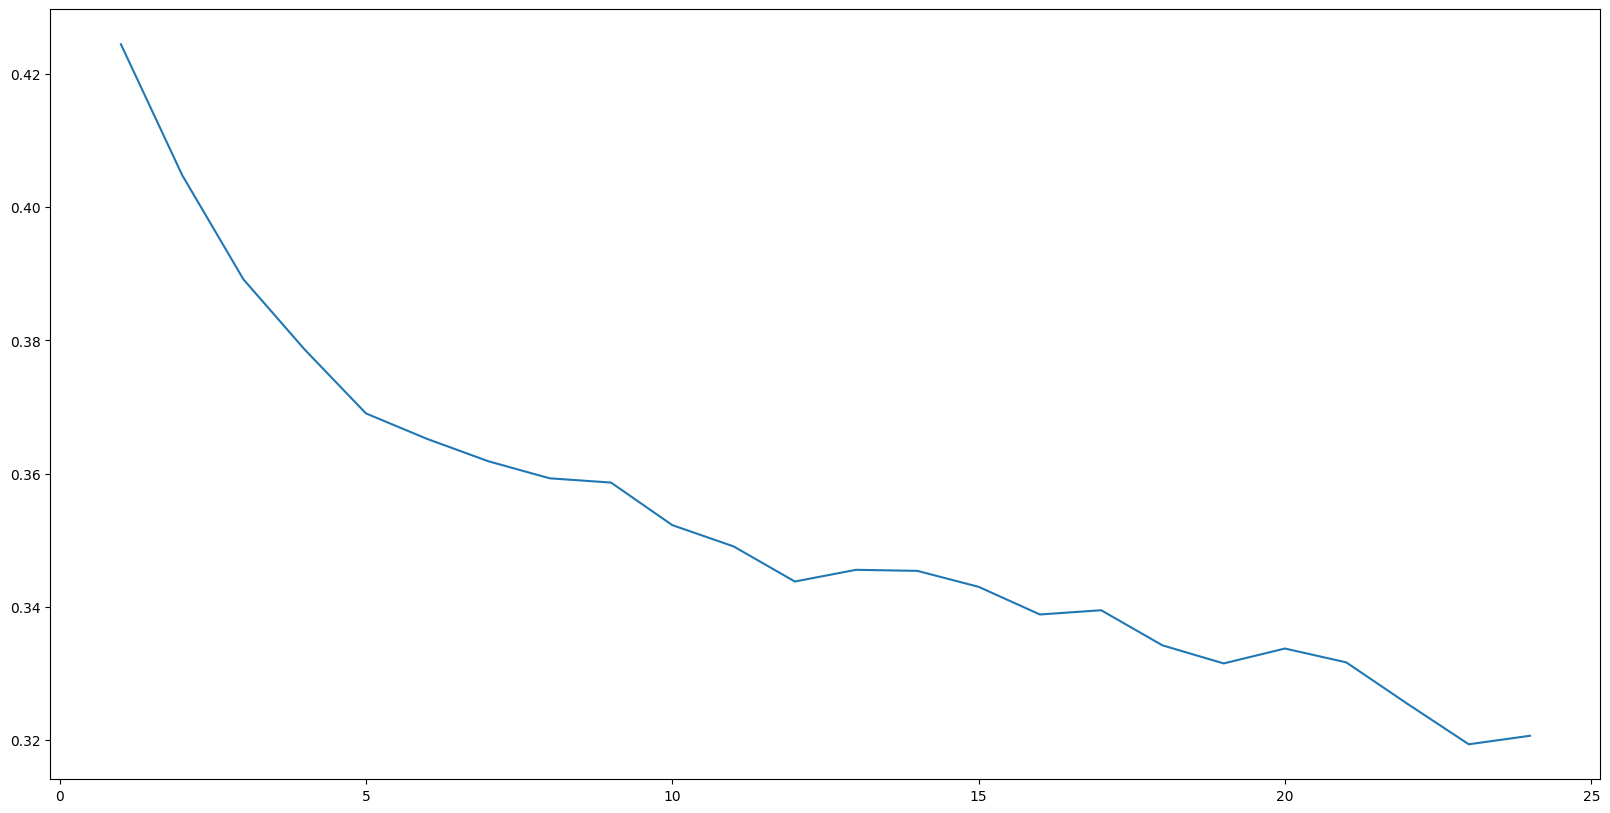

max acc at k=1 acc of 0.4244213886671987


In [ ]:
print("Using SKLEARN")
lix = []
liy = []
index=0
acc=0
for k in range(1, 25):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(d2_train_dataset, y_train)
    liy.append(neigh.score(x_test, Y_test))
    if liy[k-1]>acc:
        acc=liy[k-1]
        index=k-1
    lix.append(k)

plt.plot(lix, liy)
plt.show()
print("max acc at k="+str(index+1)+" acc of "+str(acc))

Using SKLEARN


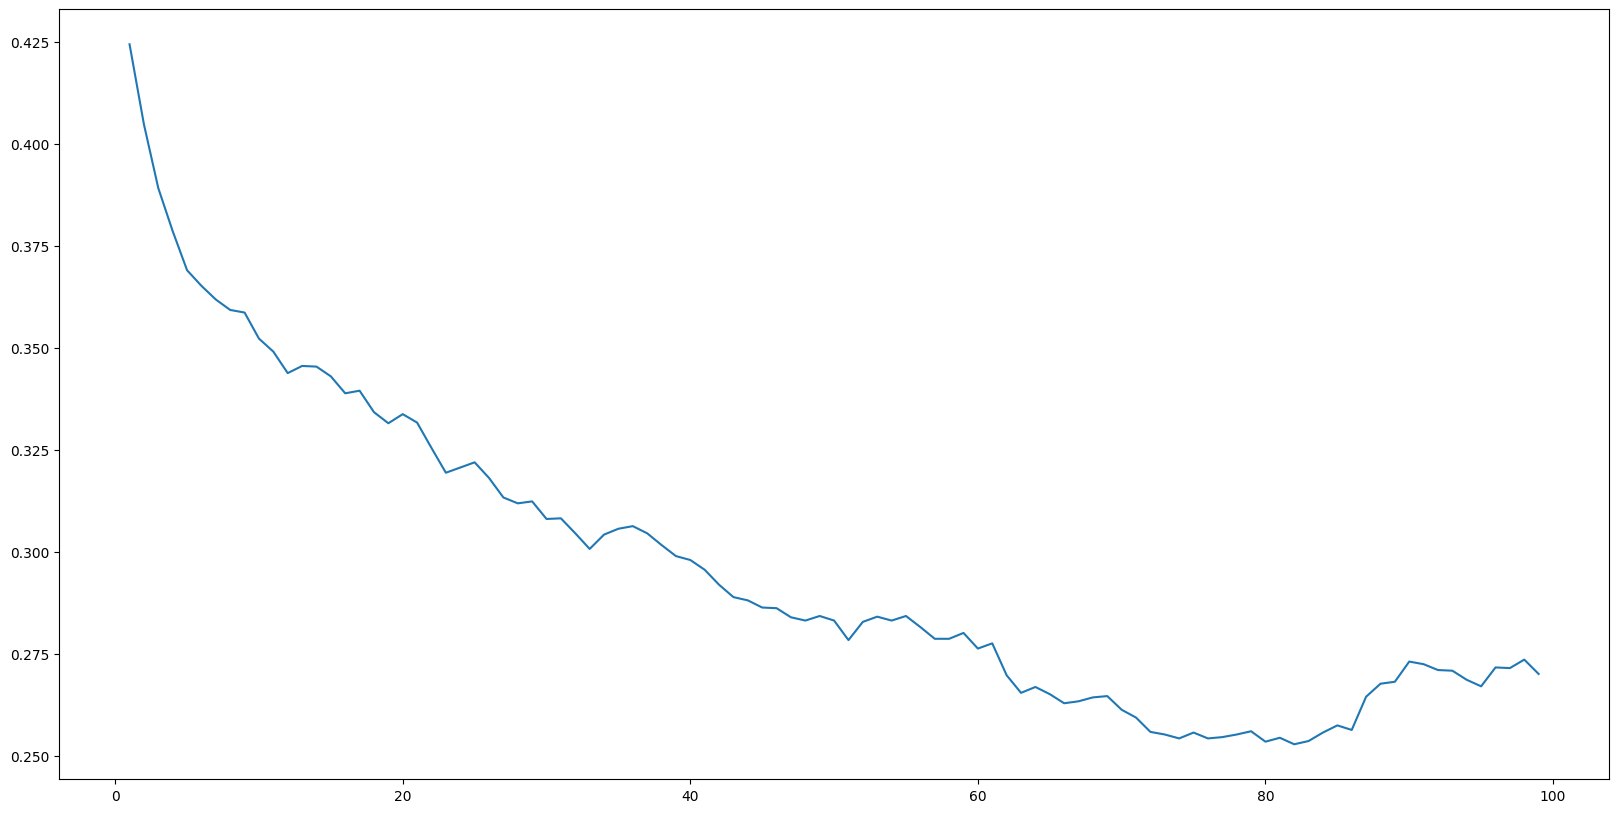

max acc at k=1 acc of 0.4244213886671987


In [ ]:
print("Using SKLEARN")
lix = []
liy = []
index=0
acc=0
for k in range(1, 100):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(d2_train_dataset, y_train)
    liy.append(neigh.score(x_test, Y_test))
    if liy[k-1]>acc:
        acc=liy[k-1]
        index=k-1
    lix.append(k)

plt.plot(lix, liy)
plt.show()
print("max acc at k="+str(index+1)+" acc of "+str(acc))

### trying custom knn function

In [ ]:
def most_common(lst):
    '''Returns the most common element in a list'''
    return max(set(lst), key=lst.count)
def euclidean(point, data):
    '''Euclidean distance between a point  & data'''
    return np.sqrt(np.sum((point - data)**2, axis=1))
class KNeighborsClassifier():
    def __init__(self, k=5, dist_metric=euclidean):
        self.k = k
        self.dist_metric = dist_metric
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
    def predict(self, X_test):
        neighbors = []
        for x in X_test:
            distances = self.dist_metric(x, self.X_train)
            y_sorted = [y for _, y in sorted(zip(distances, self.y_train))]
            neighbors.append(y_sorted[:self.k])
        return list(map(most_common, neighbors))
    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        accuracy = sum(y_pred == y_test) / len(y_test)
        return accuracy
accuracies = []
ks = range(1, 30)
for k in ks:
    knn = KNeighborsClassifier(k=k)
    knn.fit(d2_train_dataset, y_train)
    accuracy = knn.evaluate(X_test, y_test)
    accuracies.append(accuracy)
fig, ax = plt.subplots()
ax.plot(ks, accuracies)
ax.set(xlabel="k",
       ylabel="Accuracy",
       title="Performance of knn")
plt.show()

In [ ]:
# class KNearestNeighbor(object):
#     """ a kNN classifier with L2 distance """

#     def __init__(self):
#         pass

#     def predict_label(self, dists, k=1):
#         num_test = dists.shape[0]
#         y_pred = np.zeros(num_test)
#         for i in range(num_test):
#             closest_y = []
#             closest_y = self.y_train[np.argsort(dists[i])][0:k]
#             y_pred[i] = np.bincount(closest_y).argmax()
#         return y_pred

#     def train(self, X, y):
#         """
#         Train the classifier. For k-nearest neighbors this is just
#         memorizing the training data.

#         Inputs:
#         - X: A numpy array of shape (num_train, D) containing the training data
#           consisting of num_train samples each of dimension D.
#         - y: A numpy array of shape (N,) containing the training labels, where
#              y[i] is the label for X[i].
#         """
#         self.x_tr = X
#         self.y_tr = y

#     def predict(self, X, k=1):
#         """
#         Predict labels for test data using this classifier.

#         Inputs:
#         - X: A numpy array of shape (num_test, D) containing test data consisting
#              of num_test samples each of dimension D.
#         - k: The number of nearest neighbors that vote for the predicted labels.
#         - num_loops: Determines which implementation to use to compute distances
#           between training points and testing points.

#         Returns:
#         - y: A numpy array of shape (num_test,) containing predicted labels for the
#           test data, where y[i] is the predicted label for the test point X[i].
#         """
#         dists = self.compute_distances_no_loops(X)

#         return self.predict_labels(dists, k=k)

#     def compute_distances_no_loops(self, X):
#         """
#         Compute the distance between each test point in X and each training point
#         in self.x_tr using no explicit loops.

#         Input / Output: Same as compute_distances_two_loops
#         """
#         num_test = X.shape[0]
#         num_train = self.x_tr.shape[0]
#         dists = np.zeros((num_test, num_train))
#         #########################################################################
#         dists = np.sqrt((X ** 2).sum(axis=1, keepdims=1) + (self.x_tr ** 2).sum(axis=1) - 2 * X.dot(self.x_tr.T))

#         return dists

#     def predict_labels(self, dists, k=1):
#         """
#         Given a matrix of distances between test points and training points,
#         predict a label for each test point.

#         Inputs:
#         - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
#           gives the distance betwen the ith test point and the jth training point.

#         Returns:
#         - y: A numpy array of shape (num_test,) containing predicted labels for the
#           test data, where y[i] is the predicted label for the test point X[i].
#         """
#         num_test = dists.shape[0]
#         y_pred = np.zeros(num_test)
#         for i in range(num_test):
#             # A list of length k storing the labels of the k nearest neighbors to
#             # the ith test point.
#             closest_y = []
#             closest_y = self.y_tr[np.argsort(dists[i])][0:k]
#             closest_y = closest_y.astype(int)
#             y_pred[i] = np.bincount(closest_y).argmax()
#         return y_pred

In [ ]:
# dists = classifier.compute_distances_no_loops(X_val)
# y_val_pred = classifier.predict_labels(dists, k=1)
# # num_correct = np.sum(y_val_pred == y_val)
# accuracy = float(num_correct) / num_val
# print('Got %d / %d correct => accuracy: %f' % (num_correct, num_val, accuracy))

## Multiclassification with knn

In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.multiclass import OneVsRestClassifier

Splitting training dataset and training with 75% of dataset

In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(x_data, y_data, test_size=0.25, random_state=0)
ns, nx, ny, nz = X_train2.shape
X_train2 = X_train2.reshape(ns,nx*ny*nz)
nst2, nxt2, nyt2, nzt2 = X_test2.shape
X_test2 = X_test2.reshape(nst2,nxt2*nyt2*nzt2)

In [ ]:
knn = OneVsRestClassifier(KNeighborsClassifier())

In [ ]:
knn.fit(X_train2,y_train2)

OneVsRestClassifier(estimator=KNeighborsClassifier())

In [ ]:
knn.predict(X_test2[0].reshape(1,-1))

array([6])

In [ ]:
y_test2[0]

array([5])

In [ ]:
knn.predict(X_test2[:10].reshape(10,-1))

array([6, 4, 2, 2, 6, 1, 1, 6, 3, 1])

In [ ]:
y_test2[:10].reshape(1,10)

array([[5, 6, 2, 5, 0, 1, 1, 0, 4, 1]])

In [ ]:
knn.predict(x_test[0].reshape(1,-1))

array([6])

In [ ]:
Y_test[0]

array([0])

In [ ]:
knn.predict(x_test[:10].reshape(10,-1))

array([6, 1, 0, 4, 4, 6, 6, 6, 5, 6])

In [ ]:
Y_test[:10].reshape(1,10)

array([[0, 1, 4, 6, 3, 3, 2, 0, 2, 0]])

### Prediction for training dataset test set

In [ ]:
predictions_test = knn.predict(x_test)

In [ ]:
%time
print('KNN Accuracy: %.3f' % accuracy_score(Y_test,predictions_test))

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.2 µs
KNN Accuracy: 0.360


Text(0.5, 1.0, 'Accuracy Score: 0.3600957701516361')

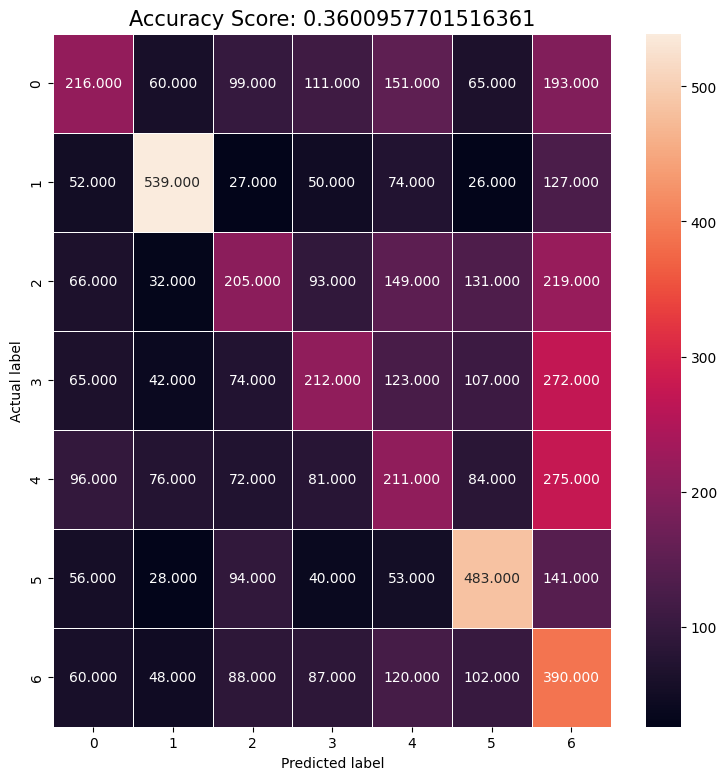

In [ ]:
conf = confusion_matrix(Y_test,predictions_test)
plt.figure(figsize=(9,9))
sns.heatmap(conf,annot=True, fmt='.3f', linewidths=.5)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(Y_test,predictions_test))
plt.title(all_sample_title,size=15)

### Same procedure for heatmap with training dataset split

In [ ]:
predictions = knn.predict(X_test2)

In [ ]:
%time
print('KNN Accuracy: %.3f' % accuracy_score(y_test2,predictions))

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs
KNN Accuracy: 0.511


Text(0.5, 1.0, 'Accuracy Score: 0.5106517779361686')

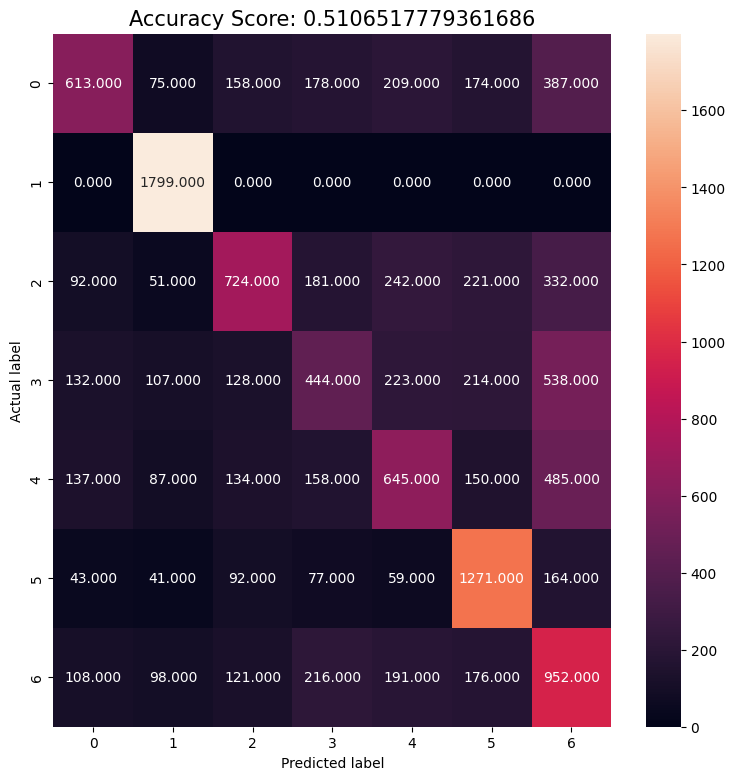

In [ ]:
cm = confusion_matrix(y_test,predictions)
plt.figure(figsize=(9,9))
sns.heatmap(cm,annot=True, fmt='.3f')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(y_test,predictions))
plt.title(all_sample_title,size=15)

# ALGO 4

# ALGO 5

In [ ]:
from sklearn.cluster import MiniBatchKMeans

In [ ]:
total_clusters = len(np.unique(Y_test))
# Initialize the K-Means model
kmeans = MiniBatchKMeans(n_clusters = total_clusters)
# Fitting the model to training set
kmeans.fit(X_train2)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


MiniBatchKMeans(n_clusters=7)

In [ ]:
kmeans.labels_

array([5, 1, 1, ..., 4, 1, 0], dtype=int32)

In [ ]:
len(kmeans.labels_)

37878

In [ ]:
len(X_train2)

37878

In [ ]:
len(y_train2)

37878

In [ ]:
def retrieve_info(cluster_labels,y_train):
    '''
    Associates most probable label with each cluster in KMeans model
    returns: dictionary of clusters assigned to each label
    '''
    # Initializing
    reference_labels = {}
    # For loop to run through each label of cluster label
    for i in range(len(np.unique(kmeans.labels_))):
        index = np.where(cluster_labels == i,1,0)
        if y_train.size:
          num = np.bincount(y_train[index==1]).argmax()
          reference_labels[i] = num
    return reference_labels

In [ ]:
ref_labels = retrieve_info(kmeans.labels_,y_train2.flatten('C'))
number_labels = np.random.rand(len(kmeans.labels_))
for i in range(len(kmeans.labels_)):
    number_labels[i] = ref_labels[kmeans.labels_[i]]

In [ ]:
number_labels[:20].astype(int)

array([6, 5, 5, 2, 2, 4, 2, 2, 3, 5, 4, 2, 6, 4, 5, 3, 6, 4, 4, 5])

In [ ]:
y_train2[1:20].reshape(1,19)

array([[6, 3, 5, 6, 3, 5, 4, 0, 2, 5, 5, 5, 0, 6, 4, 6, 4, 0, 2]])

In [ ]:
print(accuracy_score(number_labels,y_train2))

0.19578647235862506


In [ ]:
from sklearn.metrics import homogeneity_score
import warnings
warnings.filterwarnings('ignore')

We optimize k-means using 3 performance metrics: Accuracy, Inertia and Homogeneity score<br>**Accuracy** score is the percentage of correctly predicted values.<br>**Inertia** is a measure of how internally coherent clusters are. It is inversely proportional to sum of squares of distances between data points and their respective cluster’s centroid. Higher the number of clusters, lower is the inertia score.<br>**Homogeneity** score is a measure of data points of a particular cluster belonging to a single class.

In [ ]:
def calculate_metrics(model,output):
  print('Number of clusters is {}'.format(model.n_clusters))
  print('Inertia : {}'.format(model.inertia_))
  print('Homogeneity : {}'.format(homogeneity_score(output,model.labels_)))

In [ ]:
cluster_number = [4,8,10,13,20,36,48,64,144,256]
for i in cluster_number:
    total_clusters = len(np.unique(y_test2))

    kmeans = MiniBatchKMeans(n_clusters = i)

    kmeans.fit(X_train2)
    
    calculate_metrics(kmeans,y_train2.flatten('C'))

    reference_labels = retrieve_info(kmeans.labels_,y_train2.flatten('C'))

    number_labels = np.random.rand(len(kmeans.labels_))
    for i in range(len(kmeans.labels_)):
        number_labels[i] = reference_labels[kmeans.labels_[i]]
 
    print('Accuracy score : {}'.format(accuracy_score(number_labels,y_train2)))
    print()

Number of clusters is 4
Inertia : 3877825.5
Homogeneity : 0.013550036901865129
Accuracy score : 0.1926976081102487

Number of clusters is 8
Inertia : 3497851.25
Homogeneity : 0.017261314230683125
Accuracy score : 0.19998415967052113

Number of clusters is 10
Inertia : 3383480.5
Homogeneity : 0.018805556423197114
Accuracy score : 0.20038016790749247

Number of clusters is 13
Inertia : 3282949.0
Homogeneity : 0.020441029810177355
Accuracy score : 0.20420824753154865

Number of clusters is 20
Inertia : 3111492.5
Homogeneity : 0.023589479873704355
Accuracy score : 0.20901314747346744

Number of clusters is 36
Inertia : 2940026.0
Homogeneity : 0.028587897853857003
Accuracy score : 0.21796293362901947

Number of clusters is 48
Inertia : 2864481.5
Homogeneity : 0.034793271552809174
Accuracy score : 0.22514388299276625

Number of clusters is 64
Inertia : 2770362.5
Homogeneity : 0.03929392416349252
Accuracy score : 0.23187602302127885

Number of clusters is 144
Inertia : 2578718.75
Homogeneity 

Inference: The highest accuracy is returned by no. of clusters taken as 256 at 29%<br>We also notice inertia parameter decreases as no. of clusters reaches best possible. This is because distance (SSD) decreases between pixel data and centroids <br>

Other inferences: Accuracy scores increases as no. of clusters increase and homogeneity score as clusters become more and more differentiable

In [ ]:
# Testing model on testing sub-dataset (X_test2 and y_test2) for k=256

kmeans = MiniBatchKMeans(n_clusters = 256)

kmeans.fit(X_test2)
calculate_metrics(kmeans,y_test2.flatten('C'))
ref_labels = retrieve_info(kmeans.labels_,y_test2.flatten('C'))
# ‘number_labels’ is a list which denotes the number displayed in image
number_labels = np.random.rand(len(kmeans.labels_))
for i in range(len(kmeans.labels_)):
    number_labels[i] = ref_labels[kmeans.labels_[i]]
 
print('Accuracy score : {}'.format(accuracy_score(number_labels,y_test2)))
print()

Number of clusters is 256
Inertia : 799935.25
Homogeneity : 0.125900051754282
Accuracy score : 0.3009424249623822



## Minibatch K-means for performance analysis

Mini-batch k-means uses the idea of taking random smaller samples from our original high-dimensional dataset and applying k-means clustering<br>The clusters are updated with a different portion of the dataset in each iteration

In [ ]:
from sklearn.cluster import MiniBatchKMeans

In [ ]:
total_clusters = len(np.unique(Y_test))
# Initialize the K-Means model
kmeans = MiniBatchKMeans(n_clusters = total_clusters)
# Fitting the model to training set
kmeans.fit(X_train2)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


MiniBatchKMeans(n_clusters=7)

In [ ]:
kmeans.labels_

array([5, 1, 1, ..., 4, 1, 0], dtype=int32)

In [ ]:
len(kmeans.labels_)

37878

In [ ]:
len(X_train2)

37878

We infer that each data point in X_train2 has been labeled by k-means and the labels are stored in kmeans.labels_

In [ ]:
def retrieve_info(cluster_labels,y_train):
    '''
    Associates most probable label with each cluster in KMeans model
    returns: dictionary of clusters assigned to each label
    '''
    reference_labels = {}
    # For loop to run through each label of cluster label
    for i in range(len(np.unique(kmeans.labels_))):
        index = np.where(cluster_labels == i,1,0)
        if y_train.size: # Check for emptiness and None
          num = np.bincount(y_train[index==1]).argmax() # Find the highest probability label
          reference_labels[i] = num
    return reference_labels

In [ ]:
ref_labels = retrieve_info(kmeans.labels_,y_train2.flatten('C'))
number_labels = np.random.rand(len(kmeans.labels_))
for i in range(len(kmeans.labels_)):
    number_labels[i] = ref_labels[kmeans.labels_[i]]

In [ ]:
number_labels[:20].astype(int)

array([6, 5, 5, 2, 2, 4, 2, 2, 3, 5, 4, 2, 6, 4, 5, 3, 6, 4, 4, 5])

In [ ]:
y_train2[1:20].reshape(1,19)

array([[6, 3, 5, 6, 3, 5, 4, 0, 2, 5, 5, 5, 0, 6, 4, 6, 4, 0, 2]])

In [ ]:
print(accuracy_score(number_labels,y_train2))

0.19578647235862506


We get a low accuracy of 19.5% on training sub-dataset. To improve it, we go for modifying k values i.e. no. of clusters assumed

In [ ]:
from sklearn.metrics import homogeneity_score

We optimize k-means using 3 performance metrics: Accuracy, Inertia and Homogeneity score<br>**Accuracy** score is the percentage of correctly predicted values.<br>**Inertia** is a measure of how internally coherent clusters are. It is inversely proportional to sum of squares of distances between data points and their respective cluster’s centroid. Higher the number of clusters, lower is the inertia score.<br>**Homogeneity** score is a measure of data points of a particular cluster belonging to a single class.

In [ ]:
def calculate_metrics(model,output):
  print('Number of clusters is {}'.format(model.n_clusters))
  print('Inertia : {}'.format(model.inertia_))
  print('Homogeneity : {}'.format(homogeneity_score(output,model.labels_)))

In [ ]:
cluster_number = [4,8,10,13,20,36,48,64,144,256]
for i in cluster_number:
    total_clusters = len(np.unique(y_test2))

    kmeans = MiniBatchKMeans(n_clusters = i)

    kmeans.fit(X_train2)
    
    calculate_metrics(kmeans,y_train2.flatten('C'))

    reference_labels = retrieve_info(kmeans.labels_,y_train2.flatten('C'))

    number_labels = np.random.rand(len(kmeans.labels_))
    for i in range(len(kmeans.labels_)):
        number_labels[i] = reference_labels[kmeans.labels_[i]]
 
    print('Accuracy score : {}'.format(accuracy_score(number_labels,y_train2)))
    print()

Number of clusters is 4
Inertia : 3877825.5
Homogeneity : 0.013550036901865129
Accuracy score : 0.1926976081102487

Number of clusters is 8
Inertia : 3497851.25
Homogeneity : 0.017261314230683125
Accuracy score : 0.19998415967052113

Number of clusters is 10
Inertia : 3383480.5
Homogeneity : 0.018805556423197114
Accuracy score : 0.20038016790749247

Number of clusters is 13
Inertia : 3282949.0
Homogeneity : 0.020441029810177355
Accuracy score : 0.20420824753154865

Number of clusters is 20
Inertia : 3111492.5
Homogeneity : 0.023589479873704355
Accuracy score : 0.20901314747346744

Number of clusters is 36
Inertia : 2940026.0
Homogeneity : 0.028587897853857003
Accuracy score : 0.21796293362901947

Number of clusters is 48
Inertia : 2864481.5
Homogeneity : 0.034793271552809174
Accuracy score : 0.22514388299276625

Number of clusters is 64
Inertia : 2770362.5
Homogeneity : 0.03929392416349252
Accuracy score : 0.23187602302127885

Number of clusters is 144
Inertia : 2578718.75
Homogeneity 

Inference: The highest accuracy is returned by no. of clusters taken as 256 at 29%<br>We also notice inertia parameter decreases as no. of clusters reaches best possible. This is because distance (SSD) decreases between pixel data and centroids <br>

Other inferences: Accuracy scores increases as no. of clusters increase and homogeneity score as clusters become more and more differentiable

In [ ]:
# Testing model on testing sub-dataset (X_test2 and y_test2) for k=256

kmeans = MiniBatchKMeans(n_clusters = 256)

kmeans.fit(X_test2)
calculate_metrics(kmeans,y_test2.flatten('C'))
ref_labels = retrieve_info(kmeans.labels_,y_test2.flatten('C'))
# ‘number_labels’ is a list which denotes the number displayed in image
number_labels = np.random.rand(len(kmeans.labels_))
for i in range(len(kmeans.labels_)):
    number_labels[i] = ref_labels[kmeans.labels_[i]]
 
print('Accuracy score : {}'.format(accuracy_score(number_labels,y_test2)))
print()

Number of clusters is 256
Inertia : 799935.25
Homogeneity : 0.125900051754282
Accuracy score : 0.3009424249623822



Thus, we have improved the original accuracy from 19.5% to 30%

### Inference:
As concluded by PCA, we understand that k-means is not a suitable clustering method to find the classes of FER dataset by seeing the low accuracy score when compared with original labels.
<br>We also notice that the no. of classes according to our benchmark labeled dataset was 7 but k-means provided a highest accuracy for no. of clusters as 256. This shows that k-means groups the images based on different features such as orientation of the face or similar structure.